# Usarei LSTMs para prever o preço das ações da IBM para o ano de 2017

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
# First, we get the data
dataset = pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [4]:
dataset.tail()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-12-22,151.82,153.00,151.50,152.50,2990583,IBM
2017-12-26,152.51,153.86,152.50,152.83,2479017,IBM
2017-12-27,152.95,153.18,152.61,153.13,2149257,IBM
2017-12-28,153.20,154.12,153.20,154.04,2687624,IBM
2017-12-29,154.17,154.72,153.42,153.42,3327087,IBM


In [5]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

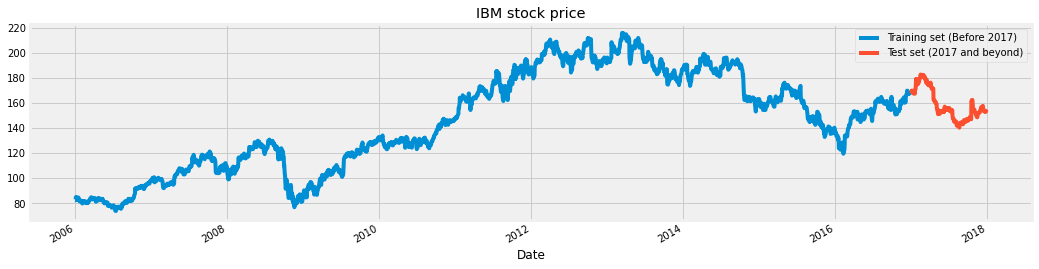

In [6]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [7]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [8]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [11]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/1
2709/2709 [==============================] - 14s 5ms/step - loss: 0.0208


In [12]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [13]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

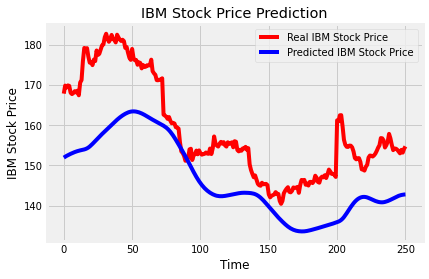

In [14]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [15]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 13.222060130526469.


LSTM não é o único tipo de unidade que conquistou o mundo do Deep Learning por uma tempestade. Temos ** Unidades Recorrentes Fechadas (GRU) **. Não se sabe, o que é melhor: GRU ou LSTM, porque eles têm desempenhos comparáveis. GRUs são mais fáceis de treinar do que LSTMs.

## GRU
Em palavras simples, a unidade GRU não precisa usar uma unidade de memória para controlar o fluxo de informações como a unidade LSTM. Ele pode usar diretamente todos os estados ocultos sem nenhum controle. As GRUs têm menos parâmetros e, portanto, podem treinar um pouco mais rápido ou precisar de menos dados para generalizar. Mas, com dados grandes, os LSTMs com maior expressividade podem levar a melhores resultados.

Eles são quase semelhantes aos LSTMs, exceto que possuem dois portões: redefinir o portão e atualizar o portão. Redefinir gate determina como combinar novas entradas à memória anterior e atualizar gate determina quanto do estado anterior deve ser mantido. O portão de atualização no GRU é o que o portão de entrada e o portão de esquecimento estavam no LSTM. Não temos a segunda não linearidade na GRU antes de calcular a saída, nem eles têm a porta de saída.


In [17]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/1
2709/2709 [==============================] - 8s 3ms/step - loss: 0.1117


The current version version uses a dense GRU network with 100 units as opposed to the GRU network with 50 units in previous version

In [18]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

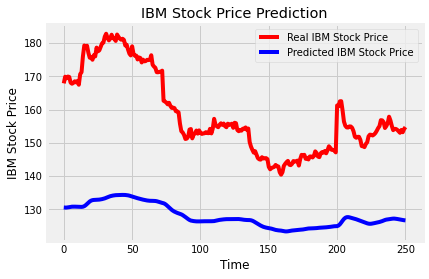

In [19]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [20]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 31.779142932589597.


## Geração de sequência
Aqui, gerarei uma sequência usando apenas 60 valores iniciais, em vez de usar os últimos 60 valores para cada nova previsão. ** Devido a dúvidas em vários comentários sobre previsões que utilizam valores do conjunto de testes, decidi incluir a geração de sequências. ** Os modelos acima fazem uso do conjunto de testes para que ele use os últimos 60 valores reais para prever o novo valor (I chamará de referência). É por isso que o erro é tão baixo. Modelos fortes também podem trazer resultados semelhantes, como os modelos acima, para seqüências, mas exigem mais do que apenas dados com valores anteriores. No caso de ações, precisamos conhecer os sentimentos do mercado, o movimento de outras ações e muito mais. Portanto, não espere uma plotagem remotamente precisa. O erro será ótimo e o melhor que posso fazer é gerar uma tendência semelhante ao conjunto de testes.

Vou usar o modelo GRU para previsões. Você pode tentar isso usando LSTMs também. Modifiquei o modelo GRU acima para obter a melhor sequência possível

In [21]:
# Preparing sequence data
initial_sequence = X_train[2708,:]
sequence = []
for i in range(251):
    new_prediction = regressorGRU.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)
sequence = sc.inverse_transform(np.array(sequence).reshape(251,1))

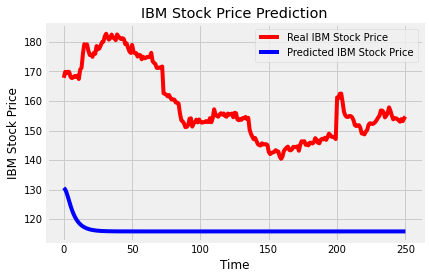

In [22]:
# Visualizing the sequence
plot_predictions(test_set,sequence)

In [23]:
# Evaluating the sequence
return_rmse(test_set,sequence)

The root mean squared error is 43.871977012679324.


So, GRU works better than LSTM in this case. Bidirectional LSTM is also a good way so make the model stronger. But this may vary for different data sets. **Applying both LSTM and GRU together gave even better results.** 

#### I was going to cover text generation using LSTM but already an excellent kernel by [Shivam Bansal](https://www.kaggle.com/shivamb) on the mentioned topic exists. Link for that kernel here: https://www.kaggle.com/shivamb/beginners-guide-to-text-generation-using-lstms

#### This is certainly not the end. Stay tuned for more stuff!